# Fixing the Vanishing Gradient Problem with Rectified Linear Unit (ReLU)

## Example Problem: Two Circles Binary Classification

To help investigate the problem, we study the classic binary classification problem. We use the [`make_circles()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html) function provided by `scikit-learn` to create a binary classification problem with given number of samples and statistical noise.

In [1]:
# import required libraries
from sklearn.datasets import make_circles
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from skorch import NeuralNetBinaryClassifier

We create the dataset with $X$ denoting the input variables (coordinates in the Cartesian plane) and the label vector $y$ denoting class values in $\{0, 1\}$. The points are arranged in two concentric circles for the two classes, with parameters:
- `n_samples`: number of points in the dataset, where half of the data points will be drawn for each circle
- `noise`: the standard deviation of the noise, `noise = 0.0` indicates no noise or points drawn exactly from the circles
- `random_state`: seed for the pseudorandom number generator for reproducibility

The statistical noise causes the overlap of the points in the two classes.

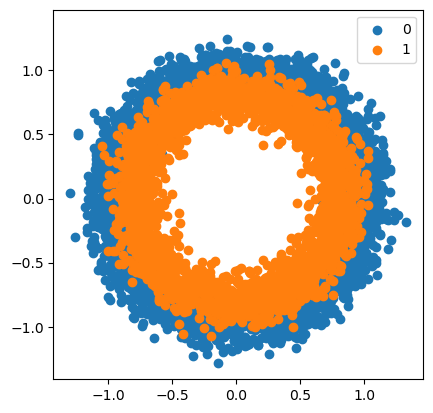

In [2]:
# generate circles
X, y = make_circles(n_samples=5000, noise=0.1, random_state=1)

for i in range(len(np.unique(y))):
    sample_indices = np.where(y == i)
    plt.scatter(X[sample_indices, 0], X[sample_indices, 1], label=str(i))
plt.legend()
plt.axis('square');

## Multi-Layer Perceptron

In [3]:
# select device based on hardware
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
# scale the data into [-1., 1.]
scaler = MinMaxScaler(feature_range=(-1., 1.))
X = scaler.fit_transform(X)

In [5]:
X, y = X.astype(np.float32), y.astype(np.float32)

In [6]:
# train/test split
num_train = int(0.8 * len(y))
trainX, testX = X[:num_train, :], X[num_train:, :]
trainy, testy = y[:num_train], y[num_train:]

In [7]:
# weight initializer function
def init_weights(module):
    if isinstance(module, torch.nn.Linear):
        torch.nn.init.uniform_(module.weight, 0., 1.)

In [8]:
# some common hyperparameters
max_epochs = 1000
lr = 0.01
verbose = 1

In [9]:
class MultiLayerPerceptronTanh(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp =  torch.nn.Sequential(
            torch.nn.Linear(in_features=2, out_features=5),
            torch.nn.Tanh(),
            torch.nn.Linear(in_features=5, out_features=1),
        )

    def forward(self, x):
        init_weights(self.mlp)
        return self.mlp(x)

In [10]:
net_tanh = NeuralNetBinaryClassifier(
    MultiLayerPerceptronTanh,
    max_epochs=max_epochs,
    lr=lr,
    device=device,
    verbose=verbose
)

In [11]:
history_tanh = net_tanh.fit(trainX, trainy)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7111       0.4188        0.7115  1.5886
      2        0.7078       0.4188        0.7086  0.0494
      3        0.7052       0.4213        0.7063  0.0449
      4        0.7032       0.4313        0.7045  0.0446
      5        0.7016       0.4512        0.7031  0.0440
      6        0.7004       0.4575        0.7020  0.0476
      7        0.6994       0.4575        0.7011  0.0444
      8        0.6986       0.4688        0.7004  0.0481
      9        0.6980       0.4713        0.6998  0.0461
     10        0.6975       0.4700        0.6993  0.0482
     11        0.6971       0.4775        0.6989  0.0438
     12        0.6967       0.4813        0.6986  0.0480
     13        0.6964       0.4825        0.6983  0.0473
     14        0.6962       0.4875        0.6981  0.0478
     15        0.6960       0.4850        0.6979  0.0510
     16        0.6958       0.4

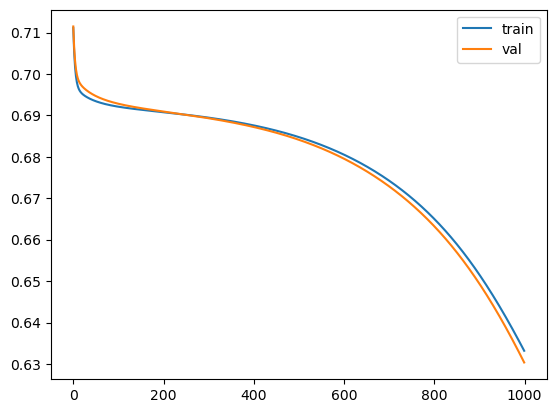

In [12]:
plt.plot(history_tanh.history[:, 'train_loss'], label='train')
plt.plot(history_tanh.history[:, 'valid_loss'], label='val')
plt.legend()
plt.show()

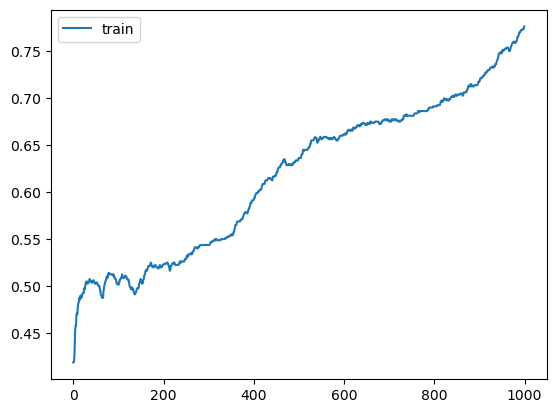

In [13]:
plt.plot(history_tanh.history[:, 'valid_acc'], label='train')
plt.legend()
plt.show()

In [14]:
# evaluate the model
predictions_tanh = net_tanh.predict(testX)
test_acc_tanh = np.sum(predictions_tanh == testy.astype(int)) / len(testy)
print(f'Average test accuracy: {test_acc_tanh}')

Average test accuracy: 0.742


In [15]:
del history_tanh

In [16]:
class MultiLayerPerceptronReLU(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp =  torch.nn.Sequential(
            torch.nn.Linear(in_features=2, out_features=5),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=5, out_features=1)
        )
    def forward(self, x):
        init_weights(self.mlp)
        return self.mlp(x)

In [17]:
net_relu = NeuralNetBinaryClassifier(
    MultiLayerPerceptronReLU,
    max_epochs=max_epochs,
    lr=lr,
    device=device,
    verbose=verbose
)

In [18]:
history_relu = net_relu.fit(trainX, trainy)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6988       0.5625        0.6965  0.0757
      2        0.6977       0.5837        0.6957  0.0591
      3        0.6969       0.5737        0.6950  0.0618
      4        0.6962       0.5687        0.6945  0.0527
      5        0.6958       0.5575        0.6941  0.0605
      6        0.6954       0.5513        0.6938  0.0557
      7        0.6951       0.5413        0.6936  0.0468
      8        0.6948       0.5350        0.6934  0.0525
      9        0.6946       0.5288        0.6932  0.0536
     10        0.6945       0.5275        0.6931  0.0529
     11        0.6943       0.5162        0.6930  0.0582
     12        0.6942       0.5150        0.6929  0.0515
     13        0.6941       0.5138        0.6928  0.0500
     14        0.6940       0.5075        0.6928  0.0491
     15        0.6940       0.5062        0.6927  0.0547
     16        0.6939       0.5

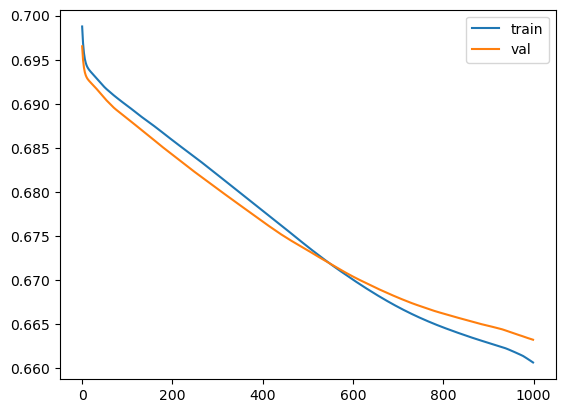

In [19]:
plt.plot(history_relu.history[:, 'train_loss'], label='train')
plt.plot(history_relu.history[:, 'valid_loss'], label='val')
plt.legend()
plt.show()

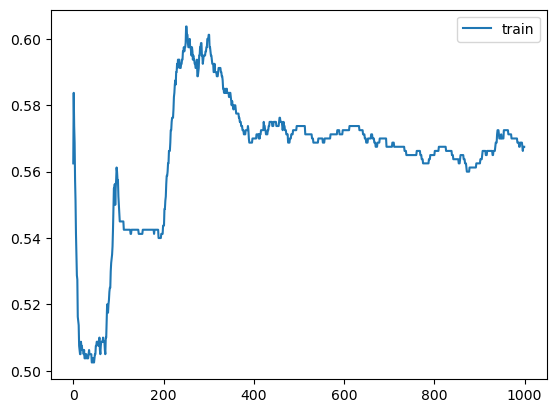

In [20]:
plt.plot(history_relu.history[:, 'valid_acc'], label='train')
plt.legend()
plt.show()

In [21]:
# evaluate the model
predictions_relu = net_relu.predict(testX)
test_acc_relu = np.sum(predictions_relu == testy.astype(int)) / len(testy)
print(f'Average test accuracy: {test_acc_relu}')

Average test accuracy: 0.555


## Deeper Models

In [22]:
layer = torch.nn.Linear(in_features=5, out_features=5)

In [23]:
# defaults to Kaiming He initialization
class DeepNeuralNetworkTanh(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.deep =  torch.nn.Sequential(
            torch.nn.Linear(in_features=2, out_features=5),
            torch.nn.Tanh(),
            layer,
            torch.nn.Tanh(),
            layer,
            torch.nn.Tanh(),
            torch.nn.Linear(in_features=5, out_features=1)
        )
    def forward(self, x):
        init_weights(self.deep)
        return self.deep(x)

In [24]:
deepnet_tanh = NeuralNetBinaryClassifier(
    DeepNeuralNetworkTanh,
    max_epochs=max_epochs,
    lr=lr,
    device=device,
    verbose=verbose
)

In [25]:
history_deeptanh = deepnet_tanh.fit(trainX, trainy)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7252       0.5012        0.7213  0.0548
      2        0.7182       0.5012        0.7151  0.0566
      3        0.7127       0.5012        0.7103  0.0606
      4        0.7084       0.5012        0.7065  0.0525
      5        0.7050       0.5012        0.7036  0.0578
      6        0.7024       0.5012        0.7013  0.0609
      7        0.7003       0.5012        0.6995  0.0531
      8        0.6987       0.5012        0.6981  0.0570
      9        0.6975       0.5012        0.6970  0.0567
     10        0.6965       0.5012        0.6961  0.0562
     11        0.6957       0.5012        0.6954  0.0530
     12        0.6951       0.5012        0.6949  0.0531
     13        0.6947       0.5012        0.6945  0.0576
     14        0.6943       0.5012        0.6942  0.0564
     15        0.6941       0.5012        0.6940  0.0585
     16        0.6938       0.5

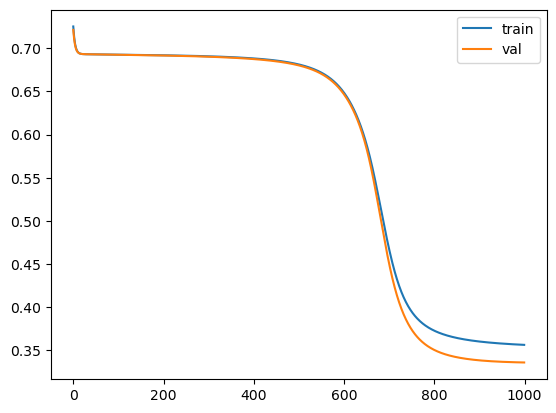

In [26]:
plt.plot(history_deeptanh.history[:, 'train_loss'], label='train')
plt.plot(history_deeptanh.history[:, 'valid_loss'], label='val')
plt.legend()
plt.show()

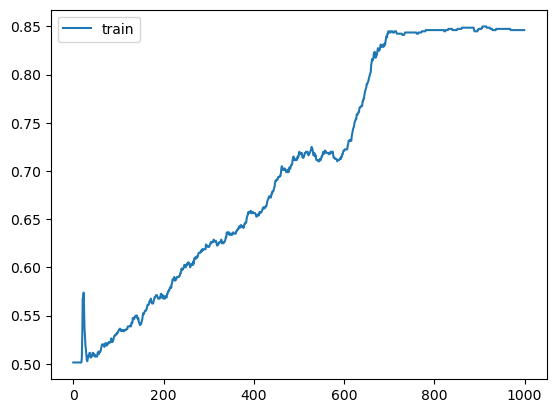

In [27]:
plt.plot(history_deeptanh.history[:, 'valid_acc'], label='train')
plt.legend()
plt.show()

In [28]:
# evaluate the model
predictions_deeptanh = deepnet_tanh.predict(testX)
test_acc_deeptanh = np.sum(predictions_deeptanh == testy.astype(int)) / len(testy)
print(f'Average test accuracy: {test_acc_deeptanh}')

Average test accuracy: 0.818


In [29]:
del history_deeptanh

In [30]:
del deepnet_tanh

In [31]:
class DeepNeuralNetworkReLU(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.deep =  torch.nn.Sequential(
            torch.nn.Linear(in_features=2, out_features=5),
            torch.nn.ReLU(),
            layer,
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=5, out_features=1)
        )
    def forward(self, x):
        init_weights(self.deep)
        return self.deep(x)

In [32]:
deepnet_relu = NeuralNetBinaryClassifier(
    DeepNeuralNetworkReLU,
    max_epochs=max_epochs,
    lr=lr,
    device=device,
    verbose=verbose
)

In [33]:
history_deeprelu = deepnet_relu.fit(trainX, trainy)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7050       0.4750        0.7063  0.0508
      2        0.7018       0.5025        0.7033  0.0528
      3        0.6994       0.4838        0.7009  0.0536
      4        0.6976       0.4775        0.6989  0.0498
      5        0.6961       0.4813        0.6972  0.0552
      6        0.6948       0.4838        0.6958  0.0591
      7        0.6937       0.4850        0.6946  0.0504
      8        0.6928       0.4925        0.6936  0.0554
      9        0.6920       0.4950        0.6929  0.0513
     10        0.6915       0.4975        0.6923  0.0514
     11        0.6911       0.4988        0.6919  0.0544
     12        0.6908       0.4938        0.6916  0.0491
     13        0.6906       0.4975        0.6914  0.0475
     14        0.6904       0.4975        0.6912  0.0460
     15        0.6902       0.4950        0.6911  0.0615
     16        0.6901       0.5

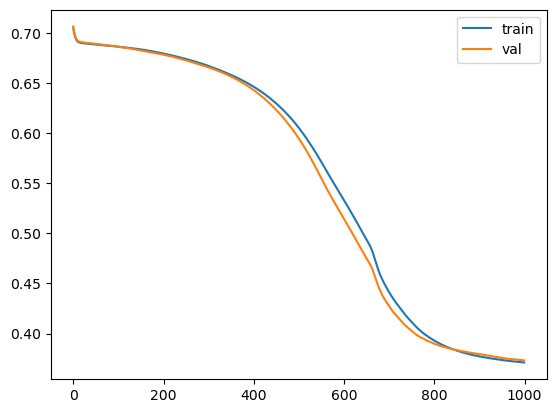

In [34]:
plt.plot(history_deeprelu.history[:, 'train_loss'], label='train')
plt.plot(history_deeprelu.history[:, 'valid_loss'], label='val')
plt.legend()
plt.show()

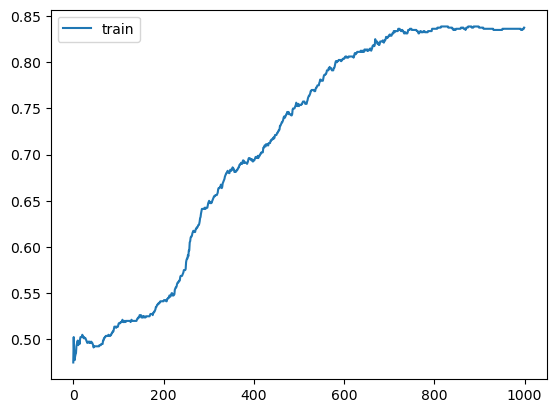

In [35]:
plt.plot(history_deeprelu.history[:, 'valid_acc'], label='train')
plt.legend()
plt.show()

In [36]:
# evaluate the model
predictions_deeprelu = deepnet_relu.predict(testX)
test_acc_deeprelu = np.sum(predictions_deeprelu == testy.astype(int)) / len(testy)
print(f'Average test accuracy: {test_acc_deeprelu}')

Average test accuracy: 0.813


In [37]:
del history_deeprelu

In [38]:
del deepnet_relu